In [1]:
#!pip install --upgrade git+https://github.com/keras-team/keras-cv

In [2]:
#!pip install -q --upgrade keras-cv
#!pip install -q --upgrade keras  # Upgrade to Keras 3.

In [3]:
#!wget "https://universe.roboflow.com/ds/UZFvFHcTp4?key=Ba0HgFQwHR" -O indoor_object_detection.zip
#!unzip "indoor_object_detection.zip" -d "dataset3/"

In [4]:
#!wget https://universe.roboflow.com/ds/GG1XJhlbDK?key=FFxqUqVjub -O indoor_object_detection.zip
#!unzip "indoor_object_detection.zip" -d "dataset1/"

## Setup

In [5]:
import os
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
import keras
import keras_cv
from keras_cv import visualization
from keras_cv import bounding_box
import datetime
import pickle

import random
import cv2

/home/andrea/tfenvl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-02 11:55:21.510044: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-02 11:55:21.620194: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 11:55:21.620245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 11:55:21.626631: E e

Using TensorFlow backend


In [6]:
# per bypassare messaggi di warning relativi all'implementazione dei layer di Data-Augmentation
tf.get_logger().setLevel('ERROR')

# impostazione per TensorFlow in modo che non allochi tutta
# la memoria della GPU ma solo quella necessaria, in modo da
# poter lanciare altri addestramenti in parallelo a questo
physical_devices = tf.config.list_physical_devices('GPU')
for pd in physical_devices:
   try:
     tf.config.experimental.set_memory_growth(pd, True)
   except:
     # device non valida/compatibile
     pass

2024-03-02 11:55:25.841637: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-02 11:55:26.016373: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-02 11:55:26.016419: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Hyperparameters

In [7]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 1.000e-03
EPOCH = 100
INITIAL_EPOCH = 0
GLOBAL_CLIPNORM = 10.0
bestResult = -1 # best MaP of previous session (-1 for new session)

DATASET_NAME = "animali"
BACKBONE_SIZE = "s"
BACKBONE_NAME ="yolo_v8_" + BACKBONE_SIZE + "_backbone_coco"
BACKBONE_TRAINABLE = False
BACKBONE_UNFREEZE = False

MODEL_NAME = "model-{size}{freezed}-{dataset}".format(size=BACKBONE_SIZE, freezed= "-bbfreez" if BACKBONE_TRAINABLE == False else "", dataset=DATASET_NAME)
HISTORY_NAME = MODEL_NAME + "-history"

#load previous training best result
if os.path.isfile(MODEL_NAME + ".pkl"):
    with open(MODEL_NAME + ".pkl", 'rb') as f:
        loaded_dict = pickle.load(f)
        bestResult = loaded_dict["BestMap"].numpy()
print(F"using best MaP: {bestResult}")

# Path to images and annotations
path_train = F"../{DATASET_NAME}/train/"
path_valid = F"../{DATASET_NAME}/test/"

# elements to use for debug callbacks (use 0 in real train process)
debug_size_train = 0
debug_size_valid = debug_size_train * SPLIT_RATIO

class_ids = [
    #"TV", "bed", "chair", "clock", "console", "consoleeeeee", "door", "fan", "light", "sofa", "switchboard", "table"
    #"emptychair", "fullchair"
    #"Chair","Sofa","Table"
    "Cane", "Gatto"
]

using best MaP: 0.594732940196991


2024-03-02 11:55:26.041179: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-02 11:55:26.041249: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-02 11:55:26.041265: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-02 11:55:28.983937: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-02 11:55:28.984044: I external/local_xla/xla/stream_executor

In [8]:
import numpy as np
a= np.array(class_ids)
print(a.shape)

(2,)


In [9]:
class_mapping = dict(zip(range(len(class_ids)), class_ids))

def GetDataFiles(path) :
# Get all XML file paths in path_annot and sort them
    xml_files = sorted(
        [
            os.path.join(path, file_name)
            for file_name in os.listdir(path)
            if file_name.endswith(".xml")
        ]
    )
    return xml_files

In [10]:

def parse_annotation(xml_file, path_images):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids

def create_object_arrays(xml_files, path, num_examples=0) :
    image_paths = []
    bbox = []
    classes = []
    i = 0
    for xml_file in tqdm(xml_files):
        i = i+1
        if num_examples > 0 and i > num_examples :
            break            
        image_path, boxes, class_ids = parse_annotation(xml_file, path)
        image_paths.append(image_path)
        bbox.append(boxes)
        classes.append(class_ids)

    return image_paths, bbox, classes

In [11]:
def get_data(path, num_examples=0):
    xmls = GetDataFiles(path)
    image_paths, bbox, classes = create_object_arrays(xmls, path, num_examples)
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)
    image_paths = tf.ragged.constant(image_paths)

    return  tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [15]:
def create_mosaic(all_img_list, all_annos, all_classes, idxs, output_size, scale_range, filter_scale=0):
    # Create an empty canvas for the output image
    output_img = np.zeros([output_size[0], output_size[1], 3], dtype=np.uint8)
    
    # Randomly select scales for dividing the output image
    scale_x = scale_range[0] + random.random() * (scale_range[1] - scale_range[0])
    scale_y = scale_range[0] + random.random() * (scale_range[1] - scale_range[0])
    
    # Calculate the dividing points based on the selected scales
    divid_point_x = int(scale_x * output_size[1])
    divid_point_y = int(scale_y * output_size[0])

    # Initialize a list for new annotations
    new_anno = []
    new_classes = []
    # Process each index and its respective image
    for i, idx in enumerate(idxs):
        path = all_img_list[idx]  # Image path
        img_annos = all_annos[idx]  # Image annotations
        img_classes = all_classes[idx]
        img = cv2.imread(path)  # Read the image
        
        # Place each image in the appropriate quadrant of the output image
        if i == 0:  # top-left quadrant
            img = cv2.resize(img, (divid_point_x, divid_point_y))
            output_img[:divid_point_y, :divid_point_x, :] = img
            class_idx = 0 
            for bbox in img_annos:  # Update annotations accordingly
                xmin = bbox[0] - bbox[0]*0.5
                ymin = bbox[1] - bbox[1]*0.5
                xmax = bbox[2] + bbox[2]*0.5
                ymax = bbox[3] + bbox[3]*0.5

                xmin *= scale_x
                ymin *= scale_y
                xmax *= scale_x
                ymax *= scale_y
                new_anno.append([int(xmin), int(ymin), int(xmax), int(ymax)])
                new_classes.append(img_classes[class_idx])
                class_idx += 1

        # Repeat the process for other quadrants (top-right, bottom-left, bottom-right)
        # Updating image placement and annotations accordingly
        
    # Filter annotations based on the provided scale
    # if 0 < filter_scale:
    #     new_anno = [anno for anno in new_anno if
    #                 filter_scale < (anno[3] - anno[1]) and filter_scale < (anno[4] - anno[2])]

    return output_img, new_anno, new_classes # Return the generated mosaic image and its annotations

In [22]:
def augment_mosaic(image_path, save_path, n_max_image, n_mosaic_images, scale_range):
    xml_files = GetDataFiles(image_path)
    np.random.seed(42)
    np.random.shuffle(xml_files)
    for i in range(0, n_max_image):
        mosiac_image_list = []
        mosiac_bbox_list = []
        mosiac_bbox_class = []
        for y in range(0, n_mosaic_images):
            idx = i+y
            path_image, boxes, class_id = parse_annotation(xml_files[idx], image_path)
            mosiac_image_list.append(path_image)
            mosiac_bbox_list.append(boxes)
            mosiac_bbox_class.append(class_id)

        idxs = np.arange(n_mosaic_images)

        output_size = (640, 640)  # Dimensions of the final mosaic image
        filter_scale = 20  # Optional filter for bounding box sizes

        # Debugging - Print out values for inspection
        print("Number of images:", len(mosiac_image_list))
        print("Number of annotations:", len(mosiac_bbox_list))
        print("Indices for mosaic:", idxs)

        # Call the mosaic function
        mosaic_img, updated_annotations, updated_classes = create_mosaic(mosiac_image_list, mosiac_bbox_list, mosiac_bbox_class, idxs, output_size, scale_range, filter_scale)

        i=0
        for ann in updated_annotations:
            color =  (255, 0, 0) if updated_classes[i] == 0 else  (255, 255, 0) 
            cv2.rectangle(mosaic_img, (ann[0], ann[1]), (ann[2], ann[3]), color, 2 )
            i+=1
        
        imgplot = plt.imshow(mosaic_img)

        # Access and use the updated_annotations for further processing
        print("Updated Annotations:")
        print(updated_annotations)

Number of images: 4
Number of annotations: 4
Indices for mosaic: [0 1 2 3]
Updated Annotations:
[[0, 0, 298, 260]]


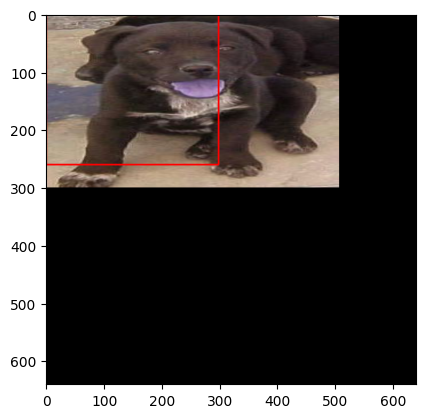

In [23]:
augment_mosaic(path_train, path_train, 1, 4, (0.4, 0.8))

In [ ]:
train_data = get_data(path_train, debug_size_train)
val_data = get_data(path_valid, debug_size_valid)
print(train_data.__len__())
print(val_data.__len__())

In [ ]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


In [ ]:
augmenter = keras.Sequential(
    layers=[

        # keras_cv.layers.RandomTranslation(
        #     height_factor=0.1,
        #     width_factor=0.1,
        #     bounding_box_format="xyxy"),
 
        keras_cv.layers.RandomHue(factor=0.015,
                                    value_range=(0., 255.)),
        keras_cv.layers.RandomBrightness(factor=0.25,
                                        value_range=(0., 255.)),
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

## Creating Training Dataset

In [ ]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

## Creating Validation Dataset

In [ ]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

## Visualization

In [ ]:

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(2)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=1
)

visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=1
)

## Check Dataset

In [ ]:
# def dict_to_tuple(inputs):
#     return inputs["images"], keras_cv.bounding_box.to_dense(
#         inputs["bounding_boxes"], max_boxes=32
#     )

def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Creating Model

In [ ]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    BACKBONE_NAME,  # We will use yolov8 small backbone with coco weights
    load_weights=True
)
backbone.trainable = BACKBONE_TRAINABLE

In [ ]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    #fpn_depth=1
)

## Compile the Model

In [ ]:
if os.path.isfile(MODEL_NAME + ".h5"):
    yolo.load_weights(MODEL_NAME + ".h5")

In [ ]:
optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

if BACKBONE_UNFREEZE == True:
    backbone.trainable = True

#yolo.summary()
    
# keras.utils.plot_model(
#     yolo,
#     show_trainable=True
#     )
    
trainable_params = 0 
for layer in yolo.trainable_weights:
    trainable_params += layer.numpy().size
print(F"Trainable Params: {trainable_params}")

In [ ]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(        
            bounding_box_format="xyxy",
            evaluate_freq=1 #1e9,
        )

        self.save_path = save_path
        self.best_map = bestResult #-1
        #self.best_map = 999

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        tot = self.data.cardinality().numpy()
        i=0
        for batch in self.data:
            i+=1
            print(F"\rCalculate Accuracy Batch {i}/{tot}", end="")
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            y_pred_ragged = bounding_box.to_ragged(y_pred)
            self.metrics.update_state(y_true, y_pred_ragged)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = logs["MaP"]
        #print(F"Calculated MaP: {current_map}")
        #current_map = logs["val_loss"]
        if current_map > self.best_map:
            self.best_map = current_map
            #Save best MaP ti file
            tosave = {"BestMap": self.best_map}
            with open(F'{self.save_path}.pkl', 'wb') as f:
                pickle.dump(tosave, f)
            now = datetime.datetime.now()
            #self.model.save(self.save_path + "-test"+ now.strftime("-%m%d%Y-%H%M%S") + ".h5")
            self.model.save(self.save_path + ".h5")

        return logs


In [ ]:
#yolo.save("model_3ep.h5")

In [ ]:
# path per i log di TensorBoard
#log_dir = "logs/fit/" + MODEL_NAME + F"-Epoch{INITIAL_EPOCH}-{EPOCH}"# + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + MODEL_NAME
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False)

## Train the Model

In [ ]:
# definizione di due callback per migliorare l'addestramento
early_stopping = keras.callbacks.EarlyStopping(monitor="MaP", patience=20, mode='max', verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="MaP", patience=5, factor=0.66, mode='max', min_lr=1.0000e-5, cooldown=5)

#coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
#    val_ds.take(2), bounding_box_format="xyxy"
#)

history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, MODEL_NAME), tensorboard_callback, early_stopping]#, early_stopping]
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, MODEL_NAME), tensorboard_callback, reduce_lr]#, early_stopping]
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, MODEL_NAME), reduce_lr]#, early_stopping]
    #callbacks=[coco_metrics_callback, tensorboard_callback, reduce_lr]#, early_stopping]
    #callbacks=[coco_metrics_callback, reduce_lr]#, early_stopping]
)

In [ ]:
#yolo.save(MODEL_NAME + "_end.h5")

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['box_loss'], label='box_loss')
plt.plot(history.history['class_loss'], label='class_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_box_loss'], label='val_box_loss')
plt.plot(history.history['val_class_loss'], label='val_class_loss')
plt.legend(loc="upper right")
plt.show()

In [ ]:
plt.plot(history.history['MaP'], label='MaP')
plt.plot(history.history['MaP@[IoU=50]'], label='MaP IoU=50')
plt.plot(history.history['MaP@[IoU=75]'], label='MaP IoU=75')
plt.plot(history.history['MaP@[area=small]'], label='MaP area small')
plt.plot(history.history['MaP@[area=medium]'], label='MaP area medium')
plt.plot(history.history['MaP@[area=large]'], label='MaP area large')
plt.legend(loc="upper right")
plt.show()

In [ ]:
plt.plot(history.history['Recall@[max_detections=1]'], label='Recall max_detections 1')
plt.plot(history.history['Recall@[max_detections=10]'], label='Recall max_detections 10')
plt.plot(history.history['Recall@[max_detections=100]'], label='Recall max_detections 100')
plt.plot(history.history['Recall@[area=small]'], label='Recall area small')
plt.plot(history.history['Recall@[area=medium]'], label='Recall area medium')
plt.plot(history.history['Recall@[area=large]'], label='Recall area large')
plt.legend(loc="upper right")
plt.show()

In [ ]:
# import pandas
# now = datetime.datetime.now()
# pandas.DataFrame.from_dict(history.history).to_csv(HISTORY_NAME + now.strftime("-%m%d%Y-%H%M%S") + '.csv',index=False)

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")